In [1]:
%matplotlib inline


Neural Transfer with PyTorch
============================
**Author**: `Alexis Jacq <https://alexis-jacq.github.io>`_

Introduction
------------

Welcome! This tutorial explains how to impletment the
`Neural-Style <https://arxiv.org/abs/1508.06576>`__ algorithm developed
by Leon A. Gatys, Alexander S. Ecker and Matthias Bethge.

Neural what?
~~~~~~~~~~~~

The Neural-Style, or Neural-Transfer, is an algorithm that takes as
input a content-image (e.g. a tortle), a style-image (e.g. artistic
waves) and return the content of the content-image as if it was
'painted' using the artistic style of the style-image:

.. figure:: /_static/img/neural-style/neuralstyle.png
   :alt: content1

How does it work?
~~~~~~~~~~~~~~~~~

The principle is simple: we define two distances, one for the content
($D_C$) and one for the style ($D_S$). $D_C$ measures
how different the content is between two images, while $D_S$
measures how different the style is between two images. Then, we take a
third image, the input, (e.g. a with noise), and we transform it in
order to both minimize its content-distance with the content-image and
its style-distance with the style-image.

OK. How does it work?
^^^^^^^^^^^^^^^^^^^^^

Well, going further requires some mathematics. Let $C_{nn}$ be a
pre-trained deep convolutional neural network and $X$ be any
image. $C_{nn}(X)$ is the network fed by $X$ (containing
feature maps at all layers). Let $F_{XL} \in C_{nn}(X)$ be the
feature maps at depth layer $L$, all vectorized and concatenated
in one single vector. We simply define the content of $X$ at layer
$L$ by $F_{XL}$. Then, if $Y$ is another image of same
the size than $X$, we define the distance of content at layer
$L$ as follow:

\begin{align}D_C^L(X,Y) = \|F_{XL} - F_{YL}\|^2 = \sum_i (F_{XL}(i) - F_{YL}(i))^2\end{align}

Where $F_{XL}(i)$ is the $i^{th}$ element of $F_{XL}$.
The style is a bit less trivial to define. Let $F_{XL}^k$ with
$k \leq K$ be the vectorized $k^{th}$ of the $K$
feature maps at layer $L$. The style $G_{XL}$ of $X$
at layer $L$ is defined by the Gram produce of all vectorized
feature maps $F_{XL}^k$ with $k \leq K$. In other words,
$G_{XL}$ is a $K$\ x\ $K$ matrix and the element
$G_{XL}(k,l)$ at the $k^{th}$ line and $l^{th}$ column
of $G_{XL}$ is the vectorial produce between $F_{XL}^k$ and
$F_{XL}^l$ :

\begin{align}G_{XL}(k,l) = \langle F_{XL}^k, F_{XL}^l\rangle = \sum_i F_{XL}^k(i) . F_{XL}^l(i)\end{align}

Where $F_{XL}^k(i)$ is the $i^{th}$ element of
$F_{XL}^k$. We can see $G_{XL}(k,l)$ as a measure of the
correlation between feature maps $k$ and $l$. In that way,
$G_{XL}$ represents the correlation matrix of feature maps of
$X$ at layer $L$. Note that the size of $G_{XL}$ only
depends on the number of feature maps, not on the size of $X$.
Then, if $Y$ is another image *of any size*, we define the
distance of style at layer $L$ as follow:

\begin{align}D_S^L(X,Y) = \|G_{XL} - G_{YL}\|^2 = \sum_{k,l} (G_{XL}(k,l) - G_{YL}(k,l))^2\end{align}

In order to minimize in one shot $D_C(X,C)$ between a variable
image $X$ and target content-image $C$ and $D_S(X,S)$
between $X$ and target style-image $S$, both computed at
several layers , we compute and sum the gradients (derivative with
respect to $X$) of each distance at each wanted layer:

\begin{align}\nabla_{	extit{total}}(X,S,C) = \sum_{L_C} w_{CL_C}.\nabla_{	extit{content}}^{L_C}(X,C) + \sum_{L_S} w_{SL_S}.\nabla_{	extit{style}}^{L_S}(X,S)\end{align}

Where $L_C$ and $L_S$ are respectivement the wanted layers
(arbitrary stated) of content and style and $w_{CL_C}$ and
$w_{SL_S}$ the weights (arbitrary stated) associated with the
style or the content at each wanted layer. Then, we run a gradient
descent over $X$:

\begin{align}X \leftarrow X - \alpha \nabla_{	extit{total}}(X,S,C)\end{align}

Ok. That's enough with maths. If you want to go deeper (how to compute
the gradients) **we encourage you to read the original paper** by Leon
A. Gatys and AL, where everything is much better and much clearer
explained. 

For our implementation in PyTorch, we already have everything
we need: indeed, with PyTorch, all the gradients are automatically and
dynamically computed for you (while you use functions from the library).
This is why the implementation of this algorithm becomes very
comfortable with PyTorch.

PyTorch implementation
----------------------

If you are not sure to understand all the mathematics above, you will
probably get it by implementing it. If you are discovering PyTorch, we
recommend you to first read this :doc:`Introduction to
PyTorch </beginner/deep_learning_60min_blitz>`.

Packages
~~~~~~~~

We will have recourse to the following packages:

-  ``torch``, ``torch.nn``, ``numpy`` (indispensables packages for
   neural networks with PyTorch)
-  ``torch.autograd.Variable`` (dynamic computation of the gradient wrt
   a variable)
-  ``torch.optim`` (efficient gradient descents)
-  ``PIL``, ``PIL.Image``, ``matplotlib.pyplot`` (load and display
   images)
-  ``torchvision.transforms`` (treat PIL images and transform into torch
   tensors)
-  ``torchvision.models`` (train or load pre-trained models)
-  ``copy`` (to deep copy the models; system package)



In [2]:
from __future__ import print_function

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

Cuda
~~~~

If you have a GPU on your computer, it is preferable to run the
algorithm on it, especially if you want to try larger networks (like
VGG). For this, we have ``torch.cuda.is_available()`` that returns
``True`` if you computer has an available GPU. Then, we can use method
``.cuda()`` that moves allocated proccesses associated with a module
from the CPU to the GPU. When we want to move back this module to the
CPU (e.g. to use numpy), we use the ``.cpu()`` method. Finally,
``.type(dtype)`` will be use to convert a ``torch.FloatTensor`` into
``torch.cuda.FloatTensor`` to feed GPU processes.




In [3]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
torch.cuda.set_device(7)

Load images
~~~~~~~~~~~

In order to simplify the implementation, let's start by importing a
style and a content image of the same dimentions. We then scale them to
the desired output image size (128 or 512 in the example, depending on gpu
availablity) and transform them into torch tensors, ready to feed
a neural network:

.. Note::
    Here are links to download the images required to run the tutorial:
    `picasso.jpg <http://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg>`__ and
    `dancing.jpg <http://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg>`__.
    Download these two images and add them to a directory
    with name ``images``



In [6]:
# desired size of the output image
imsize = 512 if use_cuda else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Scale(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image


style_img = image_loader("images/picasso.jpg").type(dtype)
content_img = image_loader("images/dancing.jpg").type(dtype)

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

/home/wengjy/py3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


Imported PIL images has values between 0 and 255. Transformed into torch
tensors, their values are between 0 and 1. This is an important detail:
neural networks from torch library are trained with 0-1 tensor image. If
you try to feed the networks with 0-255 tensor images the activated
feature maps will have no sense. This is not the case with pre-trained
networks from the Caffe library: they are trained with 0-255 tensor
images.

Display images
~~~~~~~~~~~~~~

We will use ``plt.imshow`` to display images. So we need to first
reconvert them into PIL images:




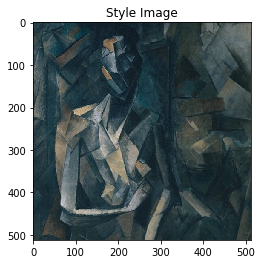

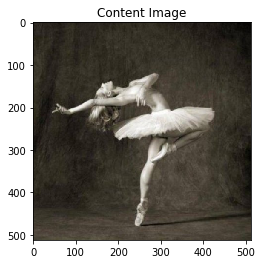

In [7]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    image = image.view(3, imsize, imsize)  # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img.data, title='Style Image')

plt.figure()
imshow(content_img.data, title='Content Image')

Content loss
~~~~~~~~~~~~

The content loss is a function that takes as input the feature maps
$F_{XL}$ at a layer $L$ in a network fed by $X$ and
return the weigthed content distance $w_{CL}.D_C^L(X,C)$ between
this image and the content image. Hence, the weight $w_{CL}$ and
the target content $F_{CL}$ are parameters of the function. We
implement this function as a torch module with a constructor that takes
these parameters as input. The distance $\|F_{XL} - F_{YL}\|^2$ is
the Mean Square Error between the two sets of feature maps, that can be
computed using a criterion ``nn.MSELoss`` stated as a third parameter.

We will add our content losses at each desired layer as additive modules
of the neural network. That way, each time we will feed the network with
an input image $X$, all the content losses will be computed at the
desired layers and, thanks to autograd, all the gradients will be
computed. For that, we just need to make the ``forward`` method of our
module returning the input: the module becomes a ''transparent layer''
of the neural network. The computed loss is saved as a parameter of the
module.

Finally, we define a fake ``backward`` method, that just call the
backward method of ``nn.MSELoss`` in order to reconstruct the gradient.
This method returns the computed loss: this will be useful when running
the gradient descent in order to display the evolution of style and
content losses.




In [8]:
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() * weight
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

.. Note::
   **Important detail**: this module, although it is named ``ContentLoss``,
   is not a true PyTorch Loss function. If you want to define your content
   loss as a PyTorch Loss, you have to create a PyTorch autograd Function
   and to recompute/implement the gradient by the hand in the ``backward``
   method.

Style loss
~~~~~~~~~~

For the style loss, we need first to define a module that compute the
gram produce $G_{XL}$ given the feature maps $F_{XL}$ of the
neural network fed by $X$, at layer $L$. Let
$\hat{F}_{XL}$ be the re-shaped version of $F_{XL}$ into a
$K$\ x\ $N$ matrix, where $K$ is the number of feature
maps at layer $L$ and $N$ the lenght of any vectorized
feature map $F_{XL}^k$. The $k^{th}$ line of
$\hat{F}_{XL}$ is $F_{XL}^k$. We let you check that
$\hat{F}_{XL} \cdot \hat{F}_{XL}^T = G_{XL}$. Given that, it
becomes easy to implement our module:




In [9]:
class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

The longer is the feature maps dimension $N$, the bigger are the
values of the gram matrix. Therefore, if we don't normalize by $N$,
the loss computed at the first layers (before pooling layers) will have
much more importance during the gradient descent. We dont want that,
since the most interesting style features are in the deepest layers!

Then, the style loss module is implemented exactly the same way than the
content loss module, but we have to add the ``gramMatrix`` as a
parameter:




In [10]:
class StyleLoss(nn.Module):

    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

Load the neural network
~~~~~~~~~~~~~~~~~~~~~~~

Now, we have to import a pre-trained neural network. As in the paper, we
are going to use a pretrained VGG network with 19 layers (VGG19).

PyTorch's implementation of VGG is a module divided in two child
``Sequential`` modules: ``features`` (containing convolution and pooling
layers) and ``classifier`` (containing fully connected layers). We are
just interested by ``features``:




In [12]:
cnn = models.vgg19(pretrained=True).features

# move it to the GPU if possible:
if use_cuda:
    cnn = cnn.cuda()

A ``Sequential`` module contains an ordered list of child modules. For
instance, ``vgg19.features`` contains a sequence (Conv2d, ReLU,
Maxpool2d, Conv2d, ReLU...) aligned in the right order of depth. As we
said in *Content loss* section, we wand to add our style and content
loss modules as additive 'transparent' layers in our network, at desired
depths. For that, we construct a new ``Sequential`` module, in wich we
are going to add modules from ``vgg19`` and our loss modules in the
right order:




In [13]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


def get_style_model_and_losses(cnn, style_img, content_img,
                               style_weight=1000, content_weight=1,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    model = nn.Sequential()  # the new Sequential module network
    gram = GramMatrix()  # we need a gram module in order to compute style targets

    # move these modules to the GPU if possible:
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()

    i = 1
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            name = "conv_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

        if isinstance(layer, nn.ReLU):
            name = "relu_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

            i += 1

        if isinstance(layer, nn.MaxPool2d):
            name = "pool_" + str(i)
            model.add_module(name, layer)  # ***

    return model, style_losses, content_losses

.. Note::
   In the paper they recommend to change max pooling layers into
   average pooling. With AlexNet, that is a small network compared to VGG19
   used in the paper, we are not going to see any difference of quality in
   the result. However, you can use these lines instead if you want to do
   this substitution:

   ::

       # avgpool = nn.AvgPool2d(kernel_size=layer.kernel_size,
       #                         stride=layer.stride, padding = layer.padding)
       # model.add_module(name,avgpool)



Input image
~~~~~~~~~~~

Again, in order to simplify the code, we take an image of the same
dimensions than content and style images. This image can be a white
noise, or it can also be a copy of the content-image.




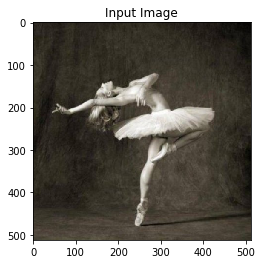

In [14]:
input_img = content_img.clone()
# if you want to use a white noise instead uncomment the below line:
# input_img = Variable(torch.randn(content_img.data.size())).type(dtype)

# add the original input image to the figure:
plt.figure()
imshow(input_img.data, title='Input Image')

Gradient descent
~~~~~~~~~~~~~~~~

As Leon Gatys, the author of the algorithm, suggested
`here <https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq>`__,
we will use L-BFGS algorithm to run our gradient descent. Unlike
training a network, we want to train the input image in order to
minimise the content/style losses. We would like to simply create a
PyTorch  L-BFGS optimizer, passing our image as the variable to optimize.
But ``optim.LBFGS`` takes as first argument a list of PyTorch
``Variable`` that require gradient. Our input image is a ``Variable``
but is not a leaf of the tree that requires computation of gradients. In
order to show that this variable requires a gradient, a possibility is
to construct a ``Parameter`` object from the input image. Then, we just
give a list containing this ``Parameter`` to the optimizer's
constructor:




In [15]:
def get_input_param_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

**Last step**: the loop of gradient descent. At each step, we must feed
the network with the updated input in order to compute the new losses,
we must run the ``backward`` methods of each loss to dynamically compute
their gradients and perform the step of gradient descent. The optimizer
requires as argument a "closure": a function that reevaluates the model
and returns the loss.

However, there's a small catch. The optimized image may take its values
between $-\infty$ and $+\infty$ instead of staying between 0
and 1. In other words, the image might be well optimized and have absurd
values. In fact, we must perform an optimization under constraints in
order to keep having right vaues into our input image. There is a simple
solution: at each step, to correct the image to maintain its values into
the 0-1 interval.




In [16]:
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_param.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.backward()
            for cl in content_losses:
                content_score += cl.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.data[0], content_score.data[0]))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_param.data.clamp_(0, 1)

    return input_param.data

Finally, run the algorithm



Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 0.138313 Content Loss: 0.468449

run [100]:
Style Loss : 0.043282 Content Loss: 0.341777

run [150]:
Style Loss : 0.035860 Content Loss: 0.315442

run [200]:
Style Loss : 0.031910 Content Loss: 0.306807

run [250]:
Style Loss : 0.030766 Content Loss: 0.302331

run [300]:
Style Loss : 0.030469 Content Loss: 0.299872



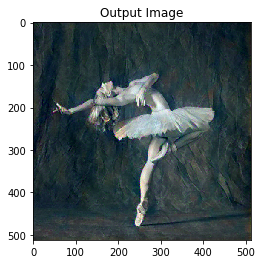

In [17]:
output = run_style_transfer(cnn, content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()